In [1]:
from datetime import datetime
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [3]:
reviewContent = pd.read_table("/Yelp_Sentiment_Analysis-master/data/reviewContent",names=["user_id","name","date","review"])
df_review = pd.DataFrame(reviewContent)

metadata = pd.read_table("/Yelp_Sentiment_Analysis-master/data/metadata",names=["user_id", "prod_id", "rating", "label", "date"])
df_metadata = pd.DataFrame(metadata)

#reviewGraph = pd.read_table("reviewGraph",names=["user_id","name","rating1"])#,names=["user_id", "prod_id", "rating", "label", "date"])
#df_reviewGraph = pd.DataFrame(reviewGraph)

combine = pd.concat([df_review,df_metadata],axis=1,join="inner")#, join_axes=[df_reviewGraph.user_id])
combine = combine.dropna()

train = combine[["label","review"]] # add date later
train.head()

#len(train[train["label"]==-1])/
#len(train)

,label,review
0,-1,"Drinks were bad, the hot chocolate was watered..."
1,-1,This was the worst experience I've ever had a ...
2,-1,This is located on the site of the old Spruce ...
3,-1,I enjoyed coffee and breakfast twice at Toast ...
4,-1,I love Toast! The food choices are fantastic -...


In [4]:
# Make duplicates of negative samples to balance the data set
train1 = pd.concat([train[train["label"]==-1],train],axis=0)
train2 = pd.concat([train[train["label"]==-1],train1],axis=0)
train3 = pd.concat([train[train["label"]==-1],train2],axis=0)
#train4 = pd.concat([train[train["label"]==-1],train3],axis=0)
balanced_train = pd.concat([train[train["label"]==-1],train3],axis=0)

# Convulotional Neural Networks

In [8]:
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(train)):
    balanced_texts.append(train.iloc[i,1])
    balanced_labels.append(train.iloc[i,0])

In [9]:
#choose the first 20000 common words and set vector size as 500
tokenizer = Tokenizer(num_words=20000)#20000
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=500)#300

In [10]:
# build model and add layers
model = Sequential()
model.add(Embedding(20000, 128, input_length=500))#20000 300
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.array(balanced_labels), test_size=0.3)

In [12]:
# fit model
model.fit(data, np.array(balanced_labels), validation_split=0.4, batch_size=200, epochs=3)
#model.fit(X_train,y_train,batch_size=200)

Train on 365074 samples, validate on 243384 samples
Epoch 1/3
365074/365074 [==============================] - 1686s 5ms/step - loss: 0.5673 - acc: 0.8658 - val_loss: 0.5680 - val_acc: 0.8699
Epoch 2/3
365074/365074 [==============================] - 1699s 5ms/step - loss: 0.5397 - acc: 0.8384 - val_loss: 0.5794 - val_acc: 0.8502
Epoch 3/3
365074/365074 [==============================] - 2424s 7ms/step - loss: 0.4843 - acc: 0.7824 - val_loss: 0.6207 - val_acc: 0.7816


In [18]:
from sklearn.preprocessing import binarize
model_pred 
class_pred = binarize(model_pred,threshold=0.5)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [27]:
for i in range(len(class_pred)):
    if class_pred[i] == 0:
        
        class_pred[i] = -1

In [10]:
#print("Report for CNN models:")
#print(classification_report(y_test, class_pred))

#print("Accuracy for lr % :",metrics.accuracy_score(y_test, model_classes)*100)


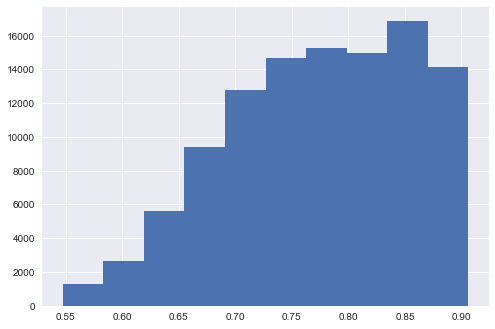

In [12]:
plt.hist(model_pred)
plt.show()

In [31]:
#Confusion matrix for SVC
print("Confusion Matric for CNN: ")
confusion_matrix(y_test,class_pred)

Confusion Matric for CNN: 


array([[    0, 11068],
       [    0, 96620]])

# Support Vector Machine

In [5]:
# a list contains each review as a list 
svc_texts = []
svc_labels = []

for i in range(len(balanced_train)):
    svc_texts.append(balanced_train.iloc[i,1])
    svc_labels.append(balanced_train.iloc[i,0])

In [6]:
# data preproccsing and fit Support Vector Machine
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
svc_classifier = LinearSVC()
Xs = vectorizer.fit_transform(svc_texts)
 
print(datetime.now() - t1)
print(Xs.shape)
 
score = cross_val_score(svc_classifier, Xs,svc_labels, cv=2, n_jobs=-1)

print(datetime.now() - t1)
print(score)
print(sum(score) / len(score))
#svc_classifier.fit(Xs, np.array(svc_labels))

0:07:13.281032
(930302, 1832756)
0:28:38.526567
[0.81257739 0.80957971]
0.8110785497637449


In [ ]:
# split data into training and testing sets
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, np.array(svc_labels), test_size=0.4)

In [ ]:
svc_classifier.fit(Xs_train, ys_train)

svc_pred = svc_classifier.predict(Xs_test)

In [ ]:
print("Report for Support Vector Machine:")
print(classification_report(ys_test, svc_pred))

#print("Accuracy for lr % :",metrics.accuracy_score(ys_test, svc_pred)*100)

In [ ]:
#draw ROC curve
fpr, tpr, thresholds = roc_curve(ys_test,svc_pred)

plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Deceptive Review Dection SVM")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

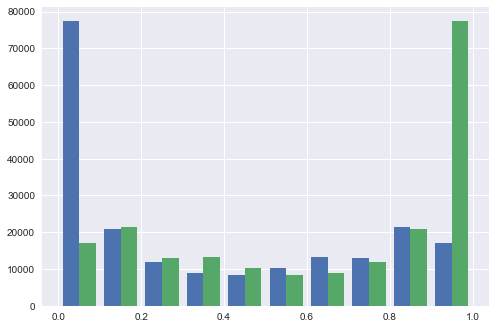

In [8]:
from sklearn.calibration import CalibratedClassifierCV

svc_to_proba = CalibratedClassifierCV(svc_classifier)

svc_to_proba.fit(Xs_train, ys_train)

svc_proba = svc_to_proba.predict_proba(Xs_test)

#probability distribution of support vector machine prediction

plt.hist(svc_proba)

plt.show()

In [14]:
#Confusion matrix for SVC before balance the data
print("Confusion Matric for SVC before balance the data: ")
confusion_matrix(ys_test,svc_pred)

Confusion Matric for SVC before balance the data: 


array([[65193,  2513],
       [11787, 64090]])

In [24]:
#Confusion matrix for SVC after balance the data
#print("Confusion Matric for SVC after balance the data: ")
#confusion_matrix(ys_test,svc_pred)

In [7]:
#store models to pickle
#from sklearn.externals import joblib

#def store_lst(text):
    #text = text
    #new_texts = []
    #for i in range(len(text)):
        #new_texts.append(text[i])
    #return new_texts

#joblib.dump(store_lst, "store_lst.pickle")
#joblib.dump(vectorizer, "tfidf_vectorizer.pickle")
#joblib.dump(svc_classifier, "svc_classifier.pickle")

['svc_classifier.pickle']

In [ ]:
# Load pickle files

#store_lst = joblib.load("store_lst.pickle")
#vectorizer = joblib.load("tfidf_vectorizer.pickle")
#classifier = joblib.load("svc_classifier.pickle")

# replace with the data you want to classify
#newtexts = store_lst(review.head()["text"])
 
# note that we should call "transform" here instead of the "fit_transform" from earlier
#Xs = vectorizer.transform(newtexts)
 
# get predictions for each of your new texts
#predictions = svc_classifier.predict(Xs)
#print(predictions)

# Predictions On New Data

In [25]:
review = pd.read_csv("review_subset.csv")

In [7]:
review.head()

,business_id,date,review_id,stars,text,user_id
0,jQsNFOzDpxPmOurSWCg1vQ,2017-06-03,ByRzJ8rF2KJWLr-cUNU6EA,1.0,"This place is horrible, we were so excited to ...",kzyLOqiJvyw_FWFTw2rjiQ
1,jQsNFOzDpxPmOurSWCg1vQ,2015-03-26,i5UwUPlQFPLcE8p2gPFwBw,4.0,"For being fairly ""fast"" food.. Pei Wei (pronou...",WZXp9-V2dqRRJqhGgRqueA
2,jQsNFOzDpxPmOurSWCg1vQ,2012-12-30,EyQyvTTg2jX4or9bB8PC9g,5.0,"I decided to try it out, I'm celiac and theref...",XylT12exfdLiI_3uDLVIpw
3,jQsNFOzDpxPmOurSWCg1vQ,2009-01-12,G-EFA005besj5uHsH0sQFA,3.0,I'm not saying Pei Wei is the best asian food ...,Ji9PeffxjwqPLO7pEfSpKQ
4,jQsNFOzDpxPmOurSWCg1vQ,2015-07-11,6PcJSGUBSLjt4VLXos5C4A,3.0,Sometimes the food is spot on and delicious an...,TLIWzAJPrET0zX4_vgvLhg


In [7]:
text = review["text"]

In [19]:
def store_lst(text):
    text = text
    new_texts = []
    for i in range(len(text)):
        new_texts.append(text[i])
    return new_texts

new_texts = store_lst(text)

In [9]:
X = vectorizer.transform(new_texts)

In [12]:
svc_classifier.fit(Xs, svc_labels)

svc_predictions = svc_classifier.predict(X)

In [13]:
y_output = list(svc_predictions)
yp=["True" if a==1 else "Deceptive" for a in y_output]
X_outputlist = list(review["text"])
star = list(review["stars"])
user_id = list(review["user_id"])
business_id = list(review["business_id"])
final_output_fm = pd.DataFrame({"user_id":user_id, "business_id":business_id,"Stars":star,'Review':X_outputlist ,'True(1)/Deceptive(0)':yp})
final_output_fm[final_output_fm["True(1)/Deceptive(0)"]=="Deceptive"]

,Review,Stars,True(1)/Deceptive(0),business_id,user_id
11,I love this place i'd recommend it to anyone !...,5.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,O7G_c6wFXSygr82qs0GAcA
20,I love Pei Wei since it's just a bit more affo...,4.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,PKZLwAGgBtQCjJtGhyPETA
29,Everything was good except Thai chicken wraps....,3.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,alTlRb9qMBX11pARX05Big
45,I love their food. I have gone there multiple ...,5.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,gRhtEXoxVpaccgvr3OkC0A
47,Very tasty Chinese food! The prices are reaso...,3.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,faaOI6hU64h6SSaF0f11eg
52,Took the family there last week. Ordered frie...,2.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,QZmG0pJlPQUq0PudwDKI5g
68,"Absolutely wonderful. This place is clean, the...",5.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,IFBx9nPxyomWzj_2prR6bg
89,We've eaten here 2-3 times a month for the las...,5.0,Deceptive,dwQEZBFen2GdihLLfWeexA,8e2Khf95bZgBlkeMqh59fA
101,"Good food, great prices, large portions, fast,...",5.0,Deceptive,dwQEZBFen2GdihLLfWeexA,is6jBVBI3fbjFOCD9cJwvA
108,This is our go to Mexican restaurant. The staf...,5.0,Deceptive,dwQEZBFen2GdihLLfWeexA,ludX46lEfeQ8TuHsK0D9zw


In [14]:
final_output_fm.to_csv('svc_predictions.csv',index=False,encoding= 'utf-8')